# Weed & Rose Detection with Ultralytics YOLO11n
This notebook trains a YOLO11n model to detect weeds and roses from an annotated dataset of bounding boxes. It defines environment settings, configuration parameters, and the training process — with options for augmentation, reproducibility, and automatic folder management.

In [5]:
# Make sure the notebook kernel is the conda env: Python (yolo)
import sys, platform, torch, os
import albumentations as A
print("Python:", sys.version)
print("OS:", platform.platform())
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Albumentations version:", A.__version__)

Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26200-SP0
CUDA available: True
GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Albumentations version: 2.0.8


In [6]:
from pathlib import Path
import yaml

PROJECT_ROOT = Path(r"D:/Ai Systems Group")
DATA_YAML    = PROJECT_ROOT / "data/weeds_yolo/data.yaml"
OUT_DIR      = PROJECT_ROOT / "work_dirs"

CFG = {
    "data": str(DATA_YAML),
    "model": "yolo11n.pt",
    "epochs": 150,
    "batch": 9,
    "imgsz": 1024,
    "workers": 6,
    "device": 0,
    "project": str(OUT_DIR),
    "name": "yolov11n-weeds",
    "exist_ok": False,
    "plots": True,
    "patience": 50,
    "seed": 42,
    # "close_mosaic": 10,
    # "cache": "ram",
}


In [7]:
with open(DATA_YAML, "r", encoding="utf-8") as f:
    ds = yaml.safe_load(f)
print(ds)


{'path': 'D:/Ai Systems Group/data/weeds_yolo', 'train': 'images/train', 'val': 'images/val', 'names': {0: 'Rose', 1: 'Weed'}}


# 3. Albumentations Augmentation Pipeline

This cell defines the **Albumentations-based image augmentations** that complement YOLO’s built-in transformations.
Albumentations provides additional *pixel-level augmentations* that help the model generalize better to real-world variations in lighting, texture, and camera quality.

---

### What it does
1. **Imports the Albumentations library** and defines a custom `Compose` pipeline named `albu_train`.
2. **Applies lightweight, complementary augmentations** on top of YOLO’s geometric ones:
   - `MotionBlur` and `MedianBlur` simulate camera shake and focus variation.
   - `RandomBrightnessContrast` adjusts brightness and contrast to improve robustness to lighting changes.
   - `CLAHE` (Contrast Limited Adaptive Histogram Equalization) enhances local contrast and texture details.
   - `ToGray` occasionally converts images to grayscale so the model doesn’t over-rely on color cues.
   - `ImageCompression` reduces quality to mimic low-end cameras or image uploads.
   - `GaussNoise` adds small random sensor noise, improving tolerance to imperfect captures.
3. Each transformation has a **low probability (`p`)** to prevent over-augmentation while maintaining dataset diversity.
4. When the `albumentations` package is installed, YOLOv11 automatically detects and integrates these augmentations during training, enhancing the overall robustness of your weed-vs-rose detection model.

In [8]:
import albumentations as A
import math

albu_train = A.Compose([
    A.MotionBlur(p=0.02, blur_limit=5),
    A.MedianBlur(p=0.02, blur_limit=5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.CLAHE(clip_limit=(1.0, 3.0), tile_grid_size=(8, 8), p=0.3),
    A.ToGray(p=0.05),
    A.ImageCompression(quality_range=(70, 100), p=0.2),

    A.GaussNoise(
        std_range=(math.sqrt(10.0) / 255.0, math.sqrt(40.0) / 255.0),
        mean_range=(0, 0),
        p=0.15
    ),
    # A.RandomCrop(p=1, )
])

# 4. Model Training
This is the main training step of the notebook.
It loads the YOLOv11n model, applies all the training configurations defined earlier (`CFG`), and begins the training process using the specified dataset and augmentations.

---

### What it does
1. **Imports and loads the YOLO model:**
   - `model = YOLO(CFG["model"])` loads the base model architecture (`yolo11n.pt`), which is the lightweight **nano version** of YOLOv11, optimized for speed and smaller datasets.
2. **Trains the model using** `model.train(...)` with all your specified parameters:
   - Dataset path (`data`)
   - Number of epochs
   - Image size and batch size
   - GPU device index
   - Output directory and run name
   - Early stopping settings (`patience`)
   - Random seed for reproducibility
3. **Includes multiple image augmentations** (both built-in YOLO and Albumentations-level options) to improve generalization.
4. **Saves results automatically** in your `OUT_DIR` folder under an experiment name such as:

In [9]:
from ultralytics import YOLO

model = YOLO(CFG["model"])
results = model.train(
    data=CFG["data"],
    epochs=CFG["epochs"],
    imgsz=CFG["imgsz"],
    batch=CFG["batch"],
    workers=CFG["workers"],
    device=CFG["device"],
    project=CFG["project"],
    name=CFG["name"],
    exist_ok=CFG["exist_ok"],
    patience=CFG["patience"],
    seed=CFG["seed"],
    plots=True,
    cls=1.0,
    weight_decay = 0.001,
    lrf = 0.0005,

    # --Augmentations--
    hsv_h=0.015, hsv_s=0.50, hsv_v=0.35,
    degrees=15.0, translate=0.06, scale=0.20, shear=5.0,
    perspective=0.0,
    flipud=0.0, fliplr=0.5,
    mosaic=0.5,
    mixup=0.1,
    close_mosaic=10,
    augmentations=albu_train
)
results


New https://pypi.org/project/ultralytics/8.3.229 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.227  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, augmentations=Compose([
  MotionBlur(p=0.02, allow_shifted=True, angle_range=(0.0, 360.0), blur_limit=(3, 5), direction_range=(-1.0, 1.0)),
  MedianBlur(p=0.02, blur_limit=(3, 5)),
  RandomBrightnessContrast(p=0.5, brightness_by_max=True, brightness_limit=(-0.15, 0.15), contrast_limit=(-0.15, 0.15), ensure_safe_range=False),
  CLAHE(p=0.3, clip_limit=(1.0, 3.0), tile_grid_size=(8, 8)),
  ToGray(p=0.05, method='weighted_average', num_output_channels=3),
  ImageCompression(p=0.2, compression_type='jpeg', quality_range=(70, 100)),
  GaussNoise(p=0.15, mean_range=(0.0, 0.0), noise_scale_factor=1.0, per_channel=True, std_range=(0.01240108886340541, 0.02480217772681082)),
], p=1.0, bbox_params=None, keypoint_params=None, add

D:\Anaconda\envs\yolo\lib\site-packages\albumentations\core\composition.py:465: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  super().__init__(


val: Fast image access  (ping: 0.30.1 ms, read: 893.9373.4 MB/s, size: 8972.3 KB)
val: Scanning D:\Ai Systems Group\data\weeds_yolo\labels\val.cache... 26 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 26/26  0.0s
Plotting labels to D:\Ai Systems Group\work_dirs\yolov11n-weeds2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.000984375), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 6 dataloader workers
Logging results to D:\Ai Systems Group\work_dirs\yolov11n-weeds2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      1/150      3.75G      2.545      7.008      2.204        238       1024: 100% ━━━━━━━━━━━━ 20/20 1.6it/s 12.8s0.3s
                 Class     Images  Instances      Box(

D:\Anaconda\envs\yolo\lib\site-packages\albumentations\core\composition.py:465: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  super().__init__(



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    141/150      3.72G      1.391      1.446      1.206        131       1024: 100% ━━━━━━━━━━━━ 20/20 2.9it/s 6.9s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.9it/s 0.4s0.9s
                   all         26        402      0.799      0.802      0.834      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    142/150      3.72G      1.328      1.315      1.167         96       1024: 100% ━━━━━━━━━━━━ 20/20 3.6it/s 5.6s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 4.6it/s 0.4s0.9s
                   all         26        402      0.853      0.758      0.836      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    143/150      3.72G      1.354      1.349       1.18        192       1024: 100% ━━━

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000296D369F010>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.048

# View training curves

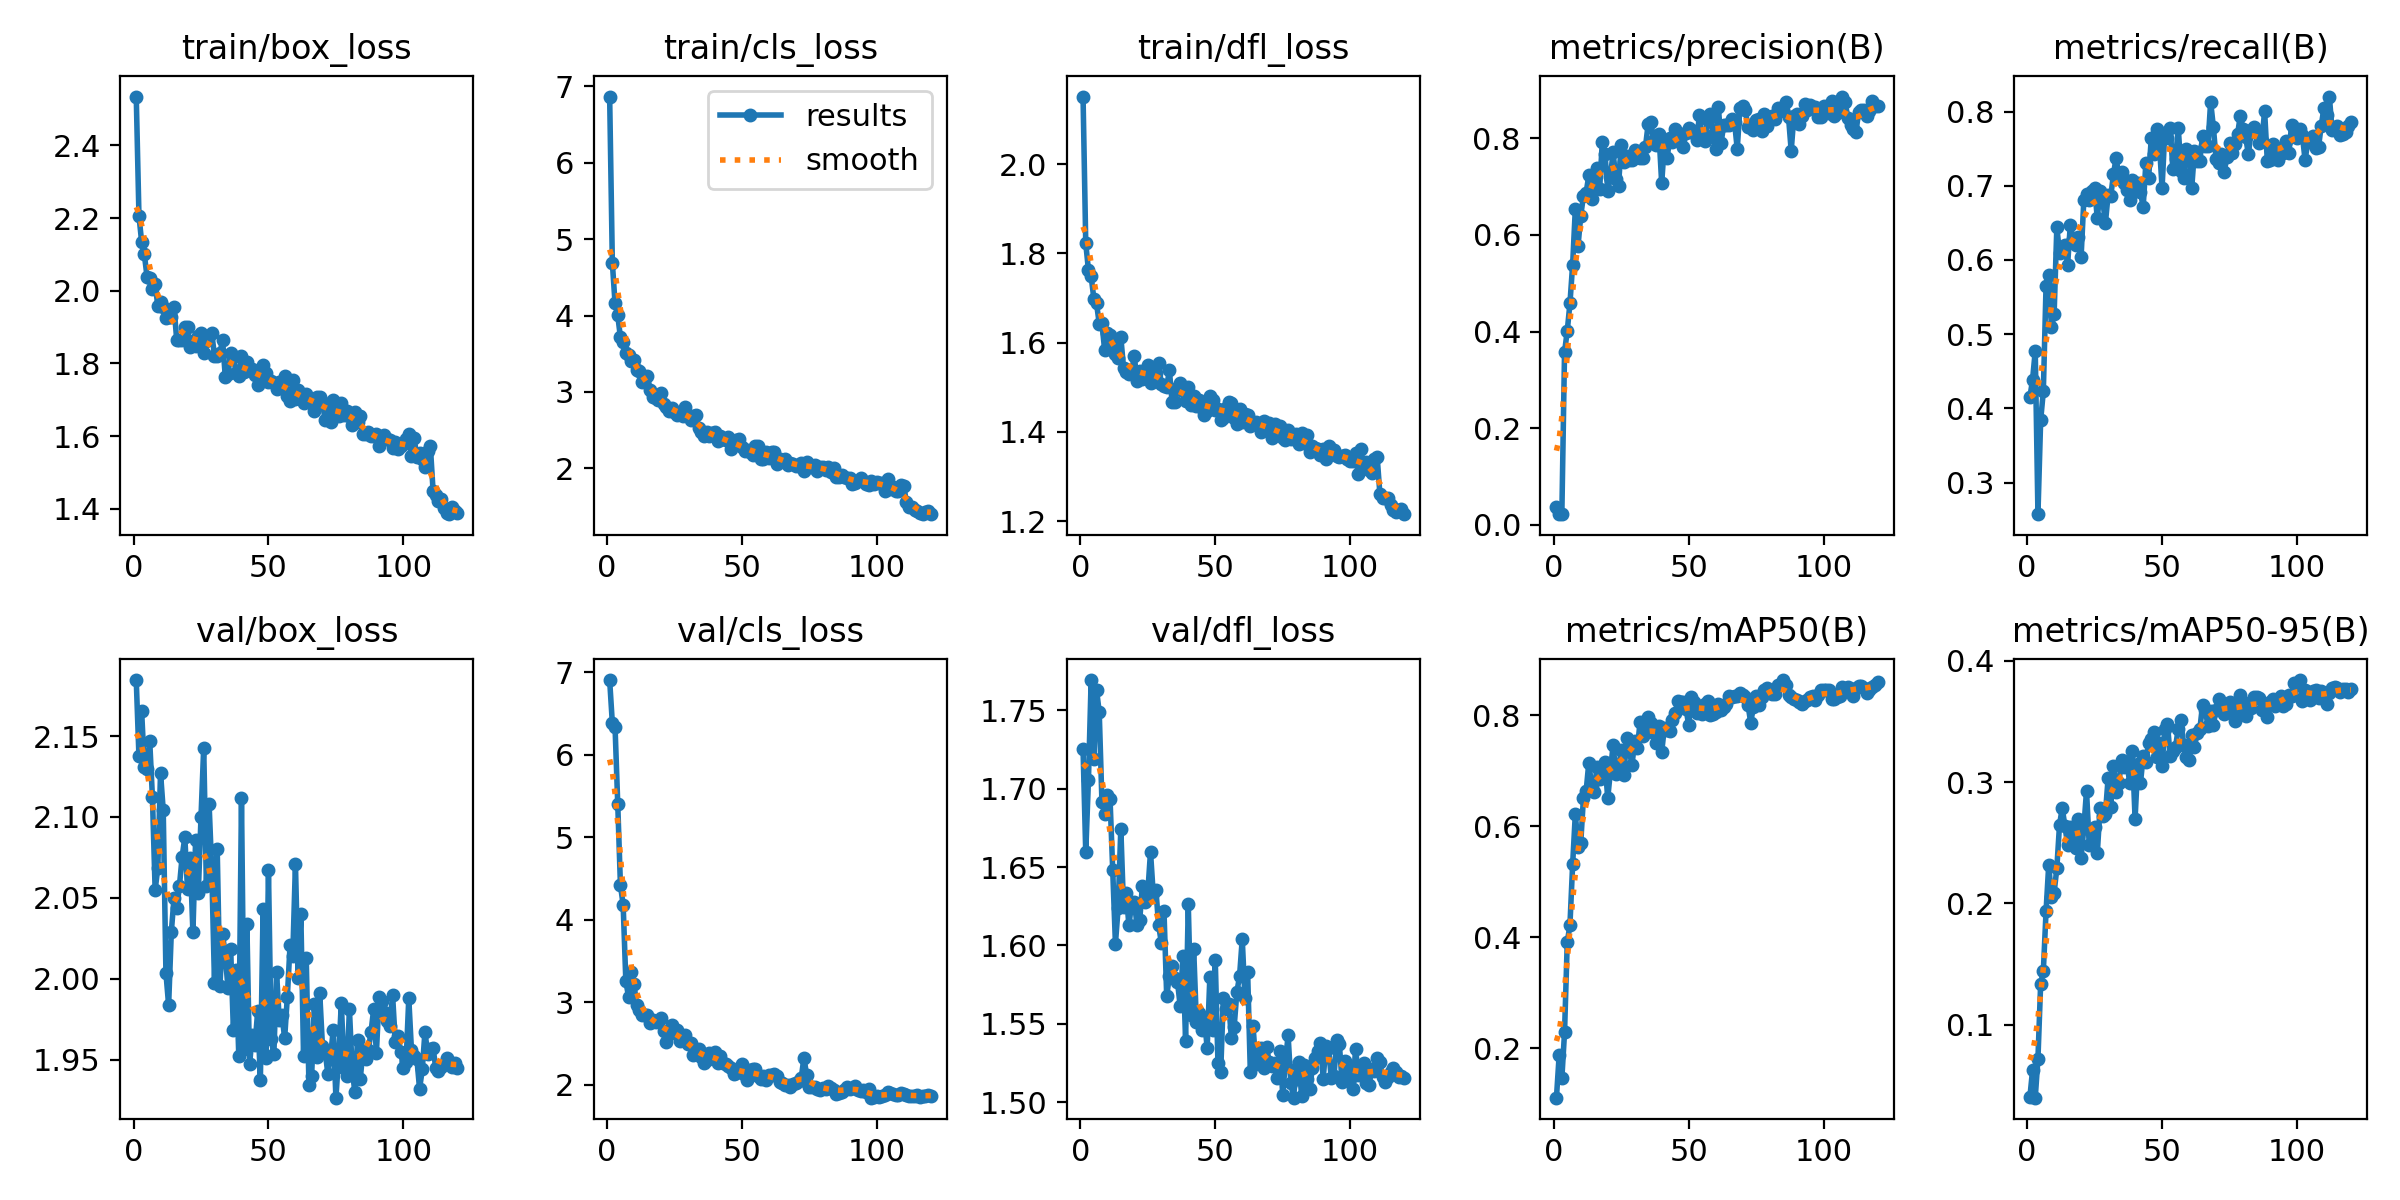

In [10]:
from IPython.display import display
from PIL import Image

run_dir = OUT_DIR / "yolov11n-weeds"
img = run_dir / "results.png"
if img.exists():
    display(Image.open(img))
else:
    print("results.png not found yet:", img)


# Validate on val set (metrics + plots)

In [11]:
metrics = model.val(
    data=CFG["data"],
    project=str(OUT_DIR),
    name=f"{CFG['name']}-val",
    plots=True
)
metrics


Ultralytics 8.3.227  Python-3.10.19 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1913.0460.7 MB/s, size: 7659.3 KB)
val: Scanning D:\Ai Systems Group\data\weeds_yolo\labels\val.cache... 26 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 26/26 13.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.2it/s 8.1s23.3s
                   all         26        402      0.828      0.786      0.834      0.368
                  Rose         26        130      0.884      0.822       0.86       0.38
                  Weed         26        272      0.773       0.75      0.809      0.356
Speed: 18.5ms preprocess, 29.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to D:\Ai Systems Group\work_dirs\yolov11n-weeds-val2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000295CFB23760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.048

# Predict on some images

In [12]:
VAL_IMAGES = Path(ds["path"]) / ds["val"]  # images/val folder
pred = model.predict(
    source=str(VAL_IMAGES),
    project=str(OUT_DIR),
    name=f"{CFG['name']}-pred",
    save=True,      # save images with drawn boxes
    save_txt=True,  # save YOLO txt predictions
    conf=0.4       # tweak for precision/recall trade-off
)
pred[:2]



image 1/26 D:\Ai Systems Group\data\weeds_yolo\images\val\073a3524-IMG_3359.JPG: 768x1024 8 Roses, 15 Weeds, 116.4ms
image 2/26 D:\Ai Systems Group\data\weeds_yolo\images\val\078e9af6-IMG_3424.JPG: 768x1024 6 Roses, 7 Weeds, 23.4ms
image 3/26 D:\Ai Systems Group\data\weeds_yolo\images\val\149e798d-IMG_3340.JPG: 768x1024 7 Roses, 4 Weeds, 20.4ms
image 4/26 D:\Ai Systems Group\data\weeds_yolo\images\val\2ab9900c-IMG_3303.JPG: 768x1024 5 Roses, 5 Weeds, 20.2ms
image 5/26 D:\Ai Systems Group\data\weeds_yolo\images\val\308c1605-IMG_3364.JPG: 768x1024 5 Roses, 12 Weeds, 21.8ms
image 6/26 D:\Ai Systems Group\data\weeds_yolo\images\val\30b69407-IMG_3305.JPG: 768x1024 5 Roses, 5 Weeds, 28.7ms
image 7/26 D:\Ai Systems Group\data\weeds_yolo\images\val\4c81fabd-IMG_3381.JPG: 768x1024 4 Roses, 7 Weeds, 34.6ms
image 8/26 D:\Ai Systems Group\data\weeds_yolo\images\val\4e57b6b0-DJI_0206.JPG: 576x1024 3 Roses, 16 Weeds, 116.6ms
image 9/26 D:\Ai Systems Group\data\weeds_yolo\images\val\4f1ba166-IMG_337

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Rose', 1: 'Weed'}
 obb: None
 orig_img: array([[[195, 197, 205],
         [197, 199, 207],
         [183, 186, 194],
         ...,
         [221, 233, 239],
         [207, 219, 225],
         [194, 206, 212]],
 
        [[202, 204, 212],
         [192, 194, 202],
         [176, 179, 187],
         ...,
         [220, 232, 238],
         [209, 221, 227],
         [203, 215, 221]],
 
        [[182, 185, 193],
         [165, 168, 176],
         [156, 159, 167],
         ...,
         [213, 226, 234],
         [206, 217, 225],
         [206, 217, 225]],
 
        ...,
 
        [[104,  78,  62],
         [103,  77,  61],
         [105,  76,  61],
         ...,
         [114, 122, 129],
         [115, 123, 130],
         [117, 125, 132]],
 
        [[104,  78,  62],
         [104,  78,  62],
         [105,  76,  61],
         ...,
         

# Visualize predictions
If you want to visualize the predictions that the model did, you can find them in the `work_dir` folder, in the folder that has the extension `-pred` at the end of the name.